In [17]:
# package import

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
# import pandas as pd
# import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
%matplotlib inline
plt.style.use('bmh')

import time


In [66]:
import numpy as np
print(np.__version__)



1.21.6


In [2]:
# Load in the data
trainDataFull = np.load('kmnist-train-imgs.npz')
trainLabelFull = np.load('kmnist-train-labels.npz')
testData = np.load('kmnist-test-imgs.npz')
testLabel = np.load('kmnist-test-labels.npz')

X_trainFull = trainDataFull['arr_0']
t_trainFull = trainLabelFull['arr_0']
X_test = testData['arr_0']
t_test = testLabel['arr_0']

assert X_trainFull.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert t_trainFull.shape == (60000,)
assert t_test.shape == (10000,)
# 10 classes of characters


In [19]:
# Train-Val split and scaling
X_train, X_val, t_train, t_val = train_test_split(
    X_trainFull, t_trainFull, test_size=0.15, random_state=24
)

X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)
X_val = X_val.reshape(X_val.shape[0], 28 * 28)

# scaling
scaler = MinMaxScaler(copy=False)

scaler.fit(X_train)
scaler.fit(X_val)
scaler.fit(X_test)


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

print(X_train.shape)

(51000, 28, 28, 1)


# First vary the loss function:
Test categorical cross entropy and MSE

In [35]:
# Base Model
# Build a CNN model
# Play with the different parameters to get a decent enough model that doesn't melt your computer
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modelbase = models.Sequential()

# Convolutional layers
modelbase.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelbase.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
modelbase.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelbase.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

# Dense layers for classification
modelbase.add(layers.Flatten())
modelbase.add(layers.Dense(128, activation='relu'))
modelbase.add(layers.Dense(64, activation='relu'))
modelbase.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs

modelbase.summary()
print(modelbase)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [36]:
# Sparse Categorical Cross Entropy
# Compile and train the model
modelbase.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbase.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Base Model with SCCE time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbase.evaluate(X_test,  t_test, verbose=2)



Epoch 1/30
1594/1594 [==============================] - 27s 16ms/step - loss: 0.4176 - accuracy: 0.9280 - val_loss: 0.1096 - val_accuracy: 0.9667
Epoch 2/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0832 - accuracy: 0.9748 - val_loss: 0.1120 - val_accuracy: 0.9672
Epoch 3/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0735 - accuracy: 0.9771 - val_loss: 0.1175 - val_accuracy: 0.9688
Epoch 4/30
1594/1594 [==============================] - 27s 17ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.1279 - val_accuracy: 0.9664
Epoch 5/30
1594/1594 [==============================] - 27s 17ms/step - loss: 0.0545 - accuracy: 0.9835 - val_loss: 0.1444 - val_accuracy: 0.9681
Epoch 6/30
1594/1594 [==============================] - 26s 17ms/step - loss: 0.0511 - accuracy: 0.9856 - val_loss: 0.1484 - val_accuracy: 0.9650
Epoch 7/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0459 - accuracy: 0.9876 - val_loss: 0.1303 -

In [37]:
# MSE
# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modelbase.compile(optimizer='nadam',
              loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbase.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Base Model with MSE time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbase.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 29s 17ms/step - loss: 27.6056 - accuracy: 0.1029 - val_loss: 27.6368 - val_accuracy: 0.0994
Epoch 2/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6053 - accuracy: 0.1102 - val_loss: 27.6368 - val_accuracy: 0.1151
Epoch 3/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6053 - accuracy: 0.1061 - val_loss: 27.6368 - val_accuracy: 0.1111
Epoch 4/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6054 - accuracy: 0.1039 - val_loss: 27.6368 - val_accuracy: 0.0992
Epoch 5/30
1594/1594 [==============================] - 25s 16ms/step - loss: 27.6054 - accuracy: 0.1062 - val_loss: 27.6368 - val_accuracy: 0.0972
Epoch 6/30
1594/1594 [==============================] - 25s 16ms/step - loss: 27.6053 - accuracy: 0.1018 - val_loss: 27.6368 - val_accuracy: 0.1119
Epoch 7/30
1594/1594 [==============================] - 25s 16ms/step - loss: 27.6054 - accuracy: 0.1047 - val_l

# Modify Batch Normalization and MaxPooling
Have results before from neither batch normalization nor max pooling. Run same architecture with batch only, pool only, and both batch and pool
Then test efficacy of dropout

In [38]:
# Batch only
# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modelbatch = models.Sequential()

# Convolutional layers
modelbatch.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelbatch.add(layers.Flatten())
modelbatch.add(layers.Dense(128, activation='relu'))
modelbatch.add(layers.Dense(64, activation='relu'))
modelbatch.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelbatch.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbatch.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbatch.evaluate(X_test,  t_test, verbose=2)


Epoch 1/30
1594/1594 [==============================] - 50s 31ms/step - loss: 0.5285 - accuracy: 0.9039 - val_loss: 0.2145 - val_accuracy: 0.9396
Epoch 2/30
1594/1594 [==============================] - 50s 31ms/step - loss: 0.1167 - accuracy: 0.9674 - val_loss: 0.1519 - val_accuracy: 0.9577
Epoch 3/30
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0841 - accuracy: 0.9754 - val_loss: 0.1048 - val_accuracy: 0.9726
Epoch 4/30
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0625 - accuracy: 0.9817 - val_loss: 0.1377 - val_accuracy: 0.9687
Epoch 5/30
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0528 - accuracy: 0.9850 - val_loss: 0.1107 - val_accuracy: 0.9720
Epoch 6/30
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0390 - accuracy: 0.9889 - val_loss: 0.1617 - val_accuracy: 0.9692
Epoch 7/30
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0360 - accuracy: 0.9905 - val_loss: 0.1549 -

In [39]:
# Pool only
# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modelpool = models.Sequential()

# Convolutional layers
modelpool.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelpool.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelpool.add(layers.MaxPooling2D((2, 2)))
modelpool.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelpool.add(layers.MaxPooling2D((2, 2)))
modelpool.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelpool.add(layers.Flatten())
modelpool.add(layers.Dense(128, activation='relu'))
modelpool.add(layers.Dense(64, activation='relu'))
modelpool.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelpool.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelpool.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelpool.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 17s 7ms/step - loss: 0.2572 - accuracy: 0.9380 - val_loss: 0.1012 - val_accuracy: 0.9686
Epoch 2/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0825 - accuracy: 0.9754 - val_loss: 0.0960 - val_accuracy: 0.9707
Epoch 3/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0668 - accuracy: 0.9807 - val_loss: 0.0897 - val_accuracy: 0.9739
Epoch 4/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0602 - accuracy: 0.9822 - val_loss: 0.0737 - val_accuracy: 0.9818
Epoch 5/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0579 - accuracy: 0.9841 - val_loss: 0.0838 - val_accuracy: 0.9772
Epoch 6/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0490 - accuracy: 0.9873 - val_loss: 0.1742 - val_accuracy: 0.9553
Epoch 7/30
1594/1594 [==============================] - 10s 7ms/step - loss: 0.0483 - accuracy: 0.9874 - val_loss: 0.1306 - val_ac

In [40]:
# Pool and Batch
# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modelboth = models.Sequential()

# Convolutional layers
modelboth.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelboth.add(layers.MaxPooling2D((2, 2)))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelboth.add(layers.MaxPooling2D((2, 2)))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelboth.add(layers.Flatten())
modelboth.add(layers.Dense(128, activation='relu'))
modelboth.add(layers.Dense(64, activation='relu'))
modelboth.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelboth.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelboth.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelboth.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 14s 8ms/step - loss: 0.1961 - accuracy: 0.9417 - val_loss: 0.0797 - val_accuracy: 0.9769
Epoch 2/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0633 - accuracy: 0.9810 - val_loss: 0.0850 - val_accuracy: 0.9771
Epoch 3/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0455 - accuracy: 0.9866 - val_loss: 0.0712 - val_accuracy: 0.9834
Epoch 4/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0352 - accuracy: 0.9898 - val_loss: 0.0612 - val_accuracy: 0.9850
Epoch 5/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 0.0999 - val_accuracy: 0.9799
Epoch 6/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.0694 - val_accuracy: 0.9838
Epoch 7/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0203 - accuracy: 0.9944 - val_loss: 0.0701 - val_ac

In [41]:
# Now try Batch+Pool with dropout
# Pool and Batch
# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
modeldrop = models.Sequential()

# Convolutional layers
modeldrop.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modeldrop.add(layers.MaxPooling2D((2, 2)))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modeldrop.add(layers.MaxPooling2D((2, 2)))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modeldrop.add(layers.Flatten())
modeldrop.add(layers.Dense(128, activation='relu'))
modeldrop.add(layers.Dense(64, activation='relu'))
modeldrop.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modeldrop.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modeldrop.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modeldrop.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 14s 8ms/step - loss: 0.3272 - accuracy: 0.9008 - val_loss: 0.1318 - val_accuracy: 0.9612
Epoch 2/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.1124 - accuracy: 0.9662 - val_loss: 0.0821 - val_accuracy: 0.9776
Epoch 3/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0824 - accuracy: 0.9757 - val_loss: 0.0821 - val_accuracy: 0.9790
Epoch 4/30
1594/1594 [==============================] - 12s 8ms/step - loss: 0.0652 - accuracy: 0.9806 - val_loss: 0.0538 - val_accuracy: 0.9848
Epoch 5/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.0545 - val_accuracy: 0.9834
Epoch 6/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0465 - accuracy: 0.9860 - val_loss: 0.0491 - val_accuracy: 0.9873
Epoch 7/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0393 - accuracy: 0.9880 - val_loss: 0.0582 - val_ac

Epoch 1/30
1594/1594 [==============================] - 16s 9ms/step - loss: 0.3252 - accuracy: 0.8998 - val_loss: 0.1447 - val_accuracy: 0.9577
Epoch 2/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.1128 - accuracy: 0.9664 - val_loss: 0.1196 - val_accuracy: 0.9677
Epoch 3/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0838 - accuracy: 0.9750 - val_loss: 0.0687 - val_accuracy: 0.9784
Epoch 4/30
1594/1594 [==============================] - 14s 8ms/step - loss: 0.0664 - accuracy: 0.9800 - val_loss: 0.0683 - val_accuracy: 0.9799
Epoch 5/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0547 - accuracy: 0.9833 - val_loss: 0.0701 - val_accuracy: 0.9802
Epoch 6/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0498 - accuracy: 0.9851 - val_loss: 0.0478 - val_accuracy: 0.9863
Epoch 7/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0411 - accuracy: 0.9876 - val_loss: 0.0625 - val_ac

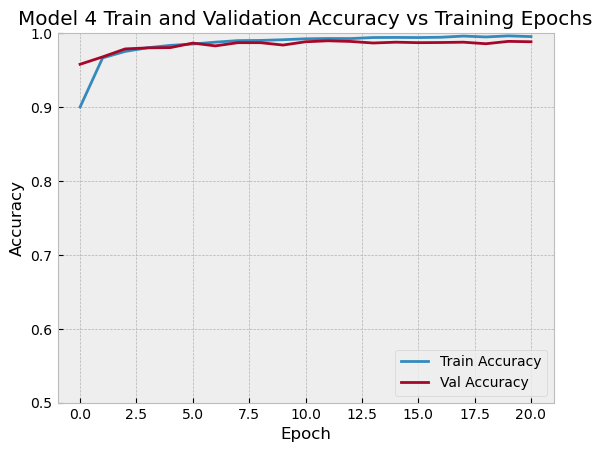

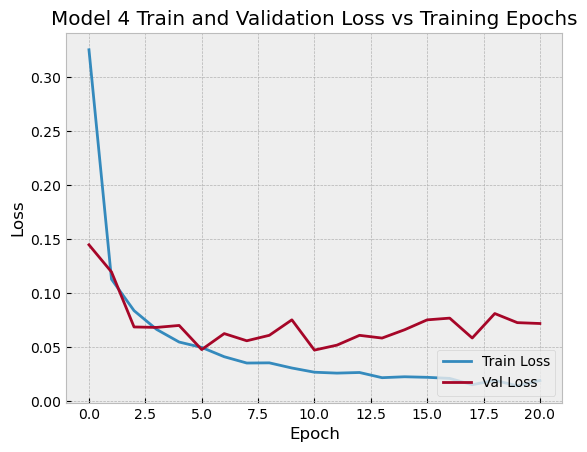

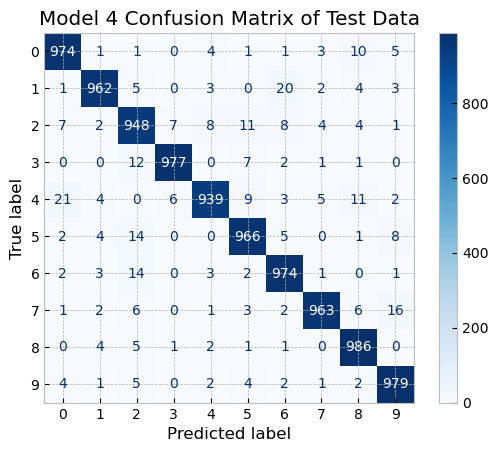

In [42]:
# Base Model with 4 conv layers

# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
model4 = models.Sequential()

# Convolutional layers
model4.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


model4.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model4.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = model4.evaluate(X_test,  t_test, verbose=2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 4 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 4 Train and Validation Loss vs Training Epochs')

predTest = model4.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 4 Confusion Matrix of Test Data')
plt.show()

Epoch 1/30
1594/1594 [==============================] - 15s 8ms/step - loss: 0.3478 - accuracy: 0.9009 - val_loss: 0.1625 - val_accuracy: 0.9493
Epoch 2/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.1151 - accuracy: 0.9654 - val_loss: 0.1020 - val_accuracy: 0.9709
Epoch 3/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0827 - accuracy: 0.9751 - val_loss: 0.0908 - val_accuracy: 0.9739
Epoch 4/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0689 - accuracy: 0.9789 - val_loss: 0.0810 - val_accuracy: 0.9774
Epoch 5/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0524 - accuracy: 0.9836 - val_loss: 0.0801 - val_accuracy: 0.9787
Epoch 6/30
1594/1594 [==============================] - 12s 8ms/step - loss: 0.0471 - accuracy: 0.9849 - val_loss: 0.0826 - val_accuracy: 0.9786
Epoch 7/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.0728 - val_ac

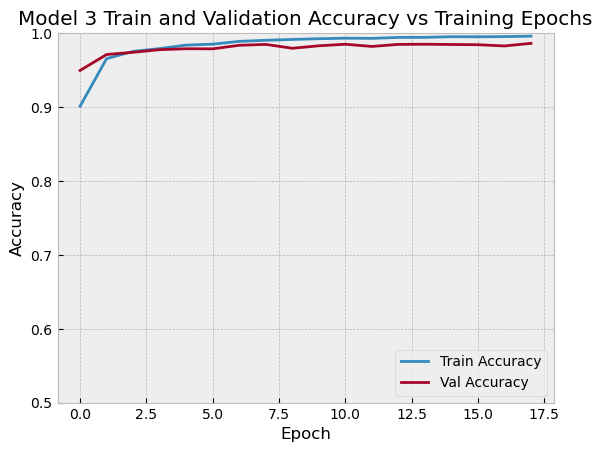

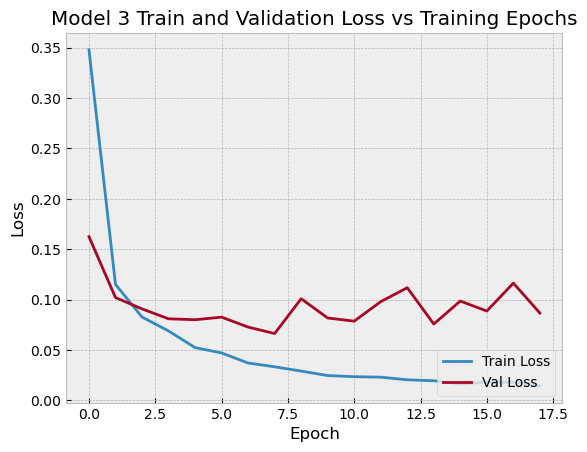

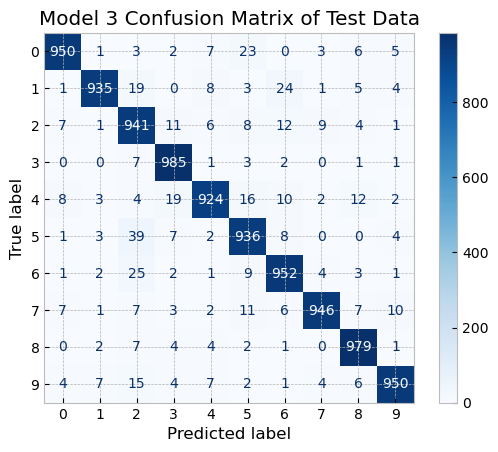

In [43]:
# Base Model with 3 conv layers

# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
model3 = models.Sequential()

# Convolutional layers
model3.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))


model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


model3.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model3.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = model3.evaluate(X_test,  t_test, verbose=2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 3 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 3 Train and Validation Loss vs Training Epochs')

predTest = model3.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 3 Confusion Matrix of Test Data')
plt.show()

Epoch 1/30
1594/1594 [==============================] - 14s 8ms/step - loss: 0.3827 - accuracy: 0.8756 - val_loss: 0.1019 - val_accuracy: 0.9669
Epoch 2/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.1472 - accuracy: 0.9542 - val_loss: 0.0933 - val_accuracy: 0.9733
Epoch 3/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.1139 - accuracy: 0.9646 - val_loss: 0.0691 - val_accuracy: 0.9798
Epoch 4/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0950 - accuracy: 0.9709 - val_loss: 0.0652 - val_accuracy: 0.9796
Epoch 5/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0816 - accuracy: 0.9749 - val_loss: 0.0592 - val_accuracy: 0.9827
Epoch 6/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0752 - accuracy: 0.9763 - val_loss: 0.0494 - val_accuracy: 0.9862
Epoch 7/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.0500 - val_ac

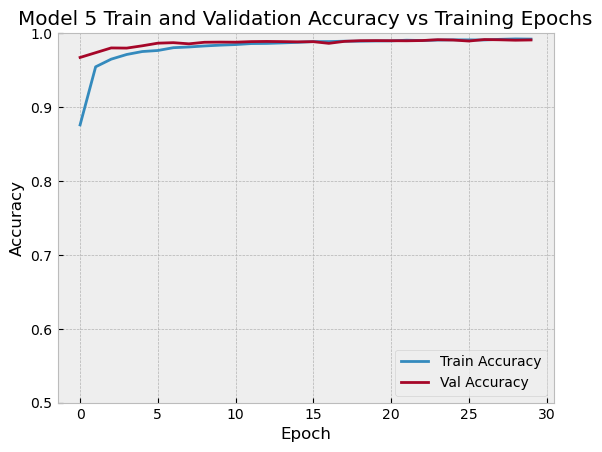

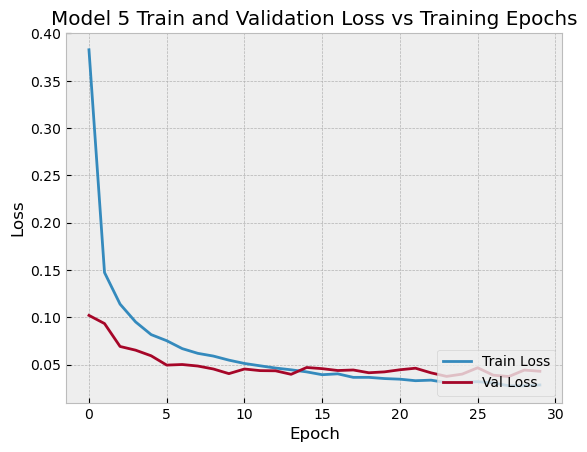

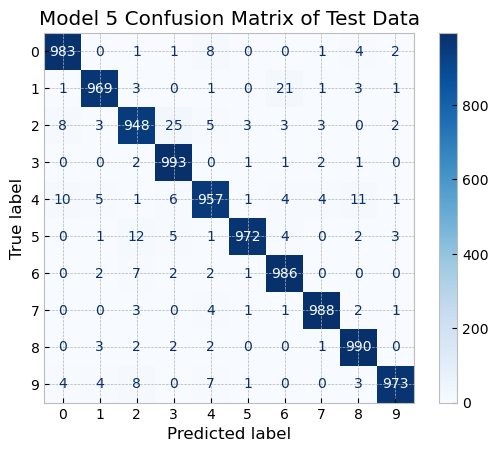

In [44]:
# Base Model with 5 conv layers

# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
model5 = models.Sequential()

# Convolutional layers
model5.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


model5.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model5.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = model5.evaluate(X_test,  t_test, verbose=2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 5 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 5 Train and Validation Loss vs Training Epochs')

predTest = model5.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 5 Confusion Matrix of Test Data')
plt.show()

Epoch 1/30
1594/1594 [==============================] - 17s 9ms/step - loss: 0.4981 - accuracy: 0.8374 - val_loss: 0.1504 - val_accuracy: 0.9566
Epoch 2/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.1837 - accuracy: 0.9437 - val_loss: 0.1279 - val_accuracy: 0.9607
Epoch 3/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.1331 - accuracy: 0.9597 - val_loss: 0.0726 - val_accuracy: 0.9806
Epoch 4/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.0578 - val_accuracy: 0.9836
Epoch 5/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.0959 - accuracy: 0.9715 - val_loss: 0.0592 - val_accuracy: 0.9833
Epoch 6/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.0840 - accuracy: 0.9745 - val_loss: 0.0505 - val_accuracy: 0.9849
Epoch 7/30
1594/1594 [==============================] - 14s 9ms/step - loss: 0.0712 - accuracy: 0.9790 - val_loss: 0.0504 - val_ac

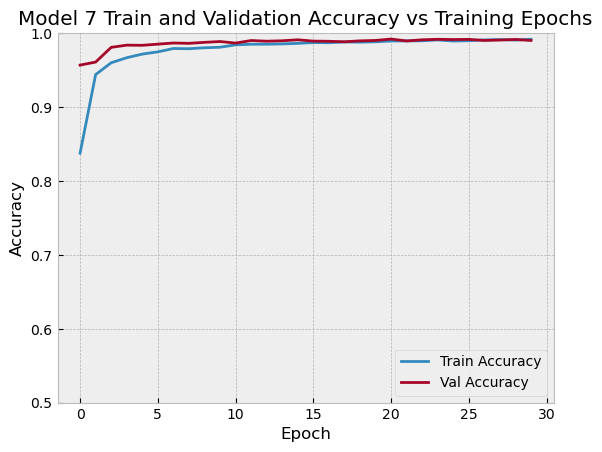

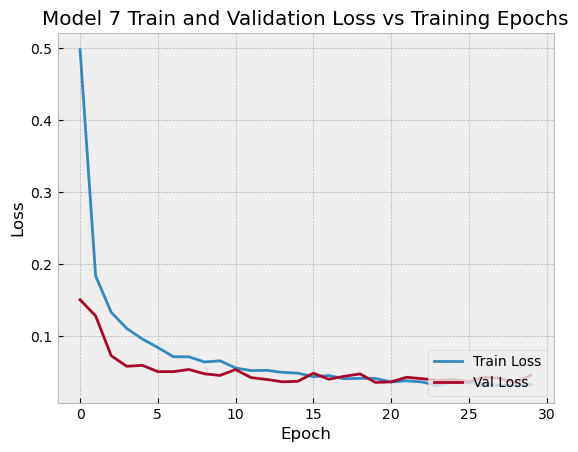

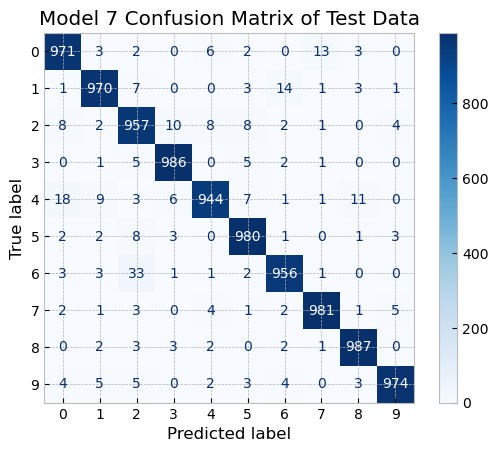

In [45]:
# Base Model with 7 conv layers

# Compile and train the model
tf.keras.backend.clear_session()
tf.random.set_seed(273)
model7 = models.Sequential()

# Convolutional layers
model7.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))
model7.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))

model7.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))
model7.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))

model7.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))
model7.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.5))

model7.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

model7.add(layers.Flatten())
model7.add(layers.Dense(128, activation='relu'))
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


model7.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model7.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = model7.evaluate(X_test,  t_test, verbose=2)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 7 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 7 Train and Validation Loss vs Training Epochs')

predTest = model7.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 7 Confusion Matrix of Test Data')
plt.show()

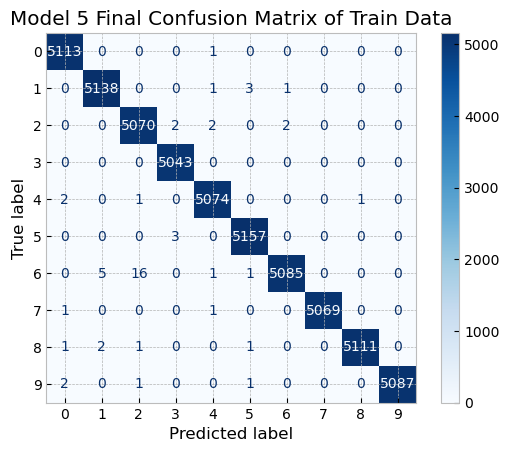

In [46]:
# Get the final train CM for the best model (the 5-conv layer model)
predTrain = model5.predict(X_train)
predClasses2 = np.argmax(predTrain, axis=1)

# Confusion matrix
cm = confusion_matrix(t_train, predClasses2)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 5 Final Confusion Matrix of Train Data')
plt.show()

In [48]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0